In [209]:
import matplotlib.pyplot as plt
import torch
words = (open('./dataset/data.txt','r')).read().splitlines()
print(words[:1])

['emma']


In [210]:
batch_size = 6
hidden_layer = 100

In [211]:
X = []
Y = []

def get(s):
    return (ord(s) - ord('a')) + 1

for word in words[:batch_size]:
    for i in range(len(word)):
        now = [0, 0, 0]
        now1 = 0
        now[1] = get(word[i])
        if(i - 1 >= 0):
            now[0] = get(word[i-1])
        if(i + 1 < len(word)):
            now[2] = get(word[i+1])
        if(i + 2 < len(word)):
            now1 = get(word[i+2])
        X.append(now)
        Y.append(now1)


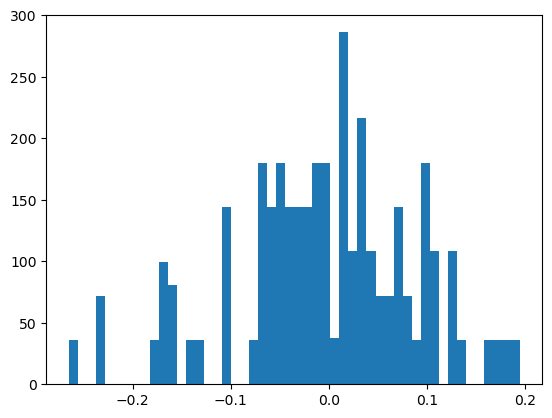

In [213]:
# uff, we have the dataset, now we make preparations
context_length = 3
g = torch.Generator().manual_seed(69)

# embeddings
C = torch.randn((27,2),generator=g,requires_grad=True)

N = C[X].view(len(C[X]),-1)
# print(N.shape)

W1 = torch.randn((context_length*2,hidden_layer),generator=g,requires_grad=True)
W1.data.mul_(0.00001)
B1 = torch.randn(hidden_layer,generator=g,requires_grad=True)
B1.data.mul_(0.1)
W2 = torch.randn((hidden_layer,27),generator=g,requires_grad=True)
W2.data.mul_(0.1)
B2 = torch.randn(27,generator=g,requires_grad=True)
B2.data.mul_(0.0)

N = torch.tanh(N@W1 + B1)
# print(N.shape)

tmp = N.view(-1)
plt.hist(tmp.tolist(),bins=50)

# TODO: add batchnorm to each hidden layer

logits = N@W2 + B2
counts = logits.exp() # remove the negative logits
probs = counts / counts.sum(1,keepdims=True)

# # plt.hist(N.view(-1).tolist(),bins=50, alpha=1)
# plt.Figure(figsize=(20,10))
# plt.imshow(N.tolist(),aspect='auto',cmap='gray',interpolation='nearest')

init loss 3.27038311958313
3.27038311958313
0.09744887799024582
0.05976494029164314
0.047731366008520126
0.04150652512907982
0.03761892020702362


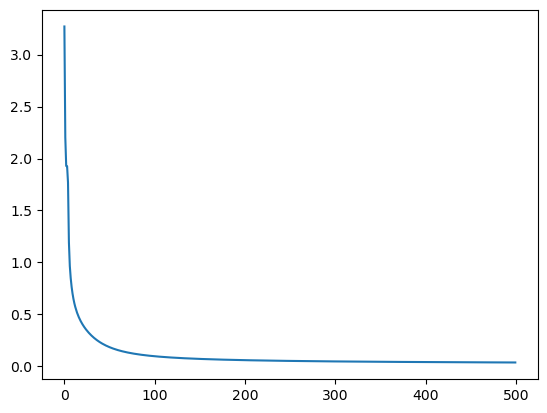

In [215]:
iterations = []
losses = []

decay_rate = 0.2
learning_rate = 3
current_rate = 3

def get_eval(probs):
    # returns the eval loss without calculating the gradients, way faster that way
    # todo
    return

def get_loss(probs):
    likelihood = 0
    for i in range(len(X)):
        pro = probs[i, Y[i]]
        likelihood += torch.log(pro)
    likelihood /= len(X)
    loss = -likelihood
    return loss


def reset_grads():
    if W1.grad is not None:
        W1.grad.zero_()
    if W2.grad is not None:
        W2.grad.zero_()
    if B1.grad is not None:
        B1.grad.zero_()
    if B2.grad is not None:
        B2.grad.zero_()
    if C.grad is not None:
        C.grad.zero_()

def gradient_descent():
    W1.data -= current_rate * W1.grad
    W2.data -= current_rate * W2.grad
    B1.data -= current_rate * B1.grad
    B2.data -= current_rate * B2.grad
    C.data -= current_rate * C.grad

def update_probs():
    N = C[X].view(len(C[X]), -1)
    N = torch.tanh(N @ W1 + B1)
    logits = N @ W2 + B2
    counts = logits.exp()
    probs = counts / counts.sum(1, keepdim=True)
    return probs

# init loss
print("init loss " + str(get_loss(probs).item()))

# Training loop
for descent in range(500):
    loss = get_loss(probs)

    # Reset gradients
    reset_grads()

    loss.backward()

    gradient_descent()

    current_rate = learning_rate * (1 / (1 + descent*decay_rate))

    probs = update_probs()

    iterations.append(descent)
    losses.append(loss.item())

    if descent % 100 == 0:
        print(loss.item())
    

plt.plot(iterations,losses)
print(loss.item())

torch.Size([27, 2])


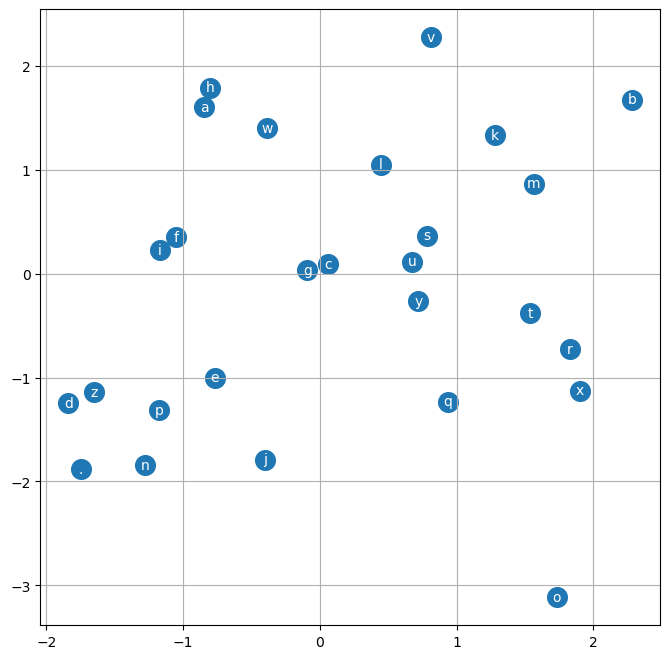

In [216]:
def get(i):
    if i == 0:
        return '.'
    else:
        return chr(ord('a') + i - 1)

plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
print(C.shape)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), get(i), ha="center", va="center", color='white')
plt.grid('minor')

In [ ]:
class Linear:
    # a liner layer of some neurons
    def __init__(self,fan_in,fan_out,bias=True):
        self.weight = torch.randn((fan_in,fan_out),generator=g)
        self.bias = torch.zeros(fan_out) if bias else None

    def __call__(self,x):
        # forward pass
        self.out = x @ self.weight
        if(self.bias is not None):
            self.out += self.bias
        return self.out
    
    def parameters(self):
        # returns all the params
        return [self.weight] + ([self.bias] if self.bias else [])

class BatchNorm1d:
    # TODO: keep track of running mean and running bias , just for effeciency when we don't have to backpropagate to create everything , good to have those things on hand
    
    # we also need to maintain
    def __init__(self,dim):
        self.training = True
        # initially everything is neutral, does not affect shit
        self.gamma = torch.ones(dim) # like weights for normalization
        self.beta = torch.zeros(dim) # bias for normalization

    def __call__(self,x):
        # ((xi - x_mean)/x_var) * gamma + beta
        if(self.training):
            # dimensions trivial here coz of 1D
            mean = x.mean(0,keepdim= True)
            var = x.var(0,keepdim=True)
            # the denominator might become 0, so we add some non significant value
            self.out = (x - mean) / torch.sqrt(var + 0.00001) 
            self.out = self.out * self.gamma + self.beta
            
        else:
            # TODO: return the running mean and var
            pass

        return self.out            

    def parameters(self):
        return [self.gamma] + [self.beta]

